In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from tqdm import tqdm # Barra de progresso para verificar o treinamento

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve

# 🌲Todas as seeds = 42

In [4]:
# Garantir que tds as seeds são 42 de acordo com o que tá escrito no quesito reprodutibilidade.

def all_seeds(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

all_seeds(42)


## ⚙️ Configurações

In [ ]:
# configurações

config = {
    'data_dir': 'dataset',
    'batch_size' : 32,
    'num_workers' : 2,
    'num_epochs' : 30, # MUITO LENTO se dxar 20(1h no colab)
    'learning_rate': 3e-5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'train_rate': 0.7,
    'val_rate' : 0.3,
    'weight_decay': 1e-4, # pra evitar o overfitting, ele minimiza o erro e mantém o peso dos neurônios pequenos // IMPORTANTE
    'model_save_path': 'modelo_colab_vision_transformers.pth'
}


In [6]:
device = torch.device(config['device'])
device

device(type='cuda')

## 📊 Análise Exploratória

In [8]:
# Transformando o dataset para um tensor

full_dataset = ImageFolder(root = config['data_dir']+ '/train', transform=treino_transforms)
im, label = full_dataset[0]
print(im.shape, label)
print(full_dataset.classes)

torch.Size([3, 224, 224]) 0
['NORMAL', 'PNEUMONIA']


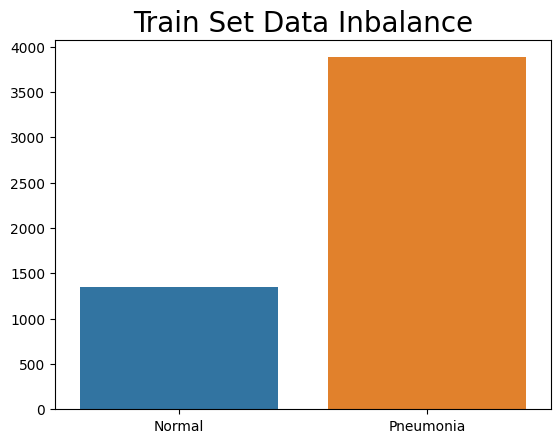

In [9]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(config['data_dir']+'/train/NORMAL', filename)
                     for filename in os.listdir(config['data_dir']+'/train/NORMAL')])],

     'Pneumonia': [len([os.path.join(config['data_dir']+'/train/PNEUMONIA', filename)
                        for filename in os.listdir(config['data_dir']+'/train/PNEUMONIA')])]})

sns.barplot(data=train_samplesize).set_title('Train Set Data Inbalance', fontsize=20)
plt.show()

Label:  NORMAL (0)


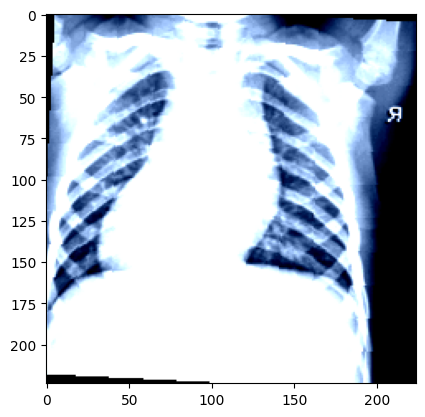

In [10]:
def samples(imagem, label):
    print(f'Label: ', full_dataset.classes[label], "("+str(label)+")")
    plt.imshow(imagem.permute(1, 2, 0))

samples(*full_dataset[523])

## 🔄 Pré-processamento

In [7]:
# Pré-processamento de data

normal_mean = [0.485, 0.456, 0.406] # média imagenet
normal_std = [0.229, 0.224, 0.225] # standard do imagenet

treino_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # útil em imagens médicas porque varia mais
    transforms.ToTensor(),
    transforms.Normalize(mean=normal_mean, std=normal_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normal_mean, std=normal_std)
])

## 📂 Dataset e Split Treino/Validação

In [11]:
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


In [12]:
# DataLoaders

train_loader = DataLoader(
    train_dataset,
    batch_size = config['batch_size'],
    shuffle = True,
    num_workers = config['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = config['batch_size'],
    shuffle = False,
    num_workers = config['num_workers'],
    pin_memory=True
)

print(f"Treino:    {len(train_dataset)} imagens")
print(f"Validação: {len(val_dataset)} imagens")


Treino:    3662 imagens
Validação: 1570 imagens


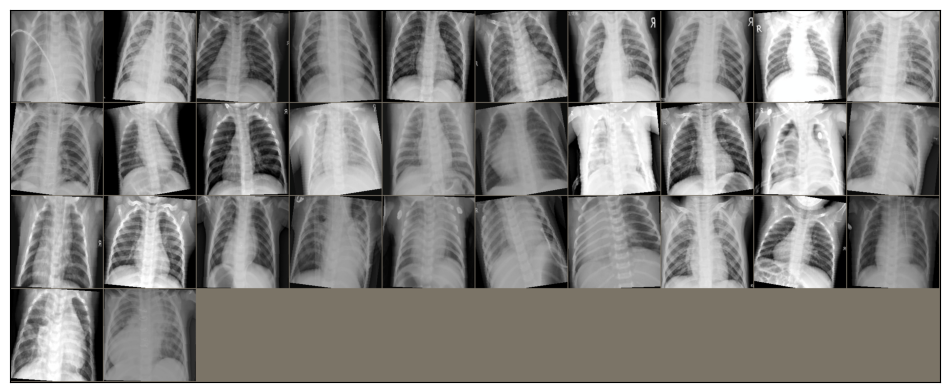

In [13]:
def show_batch(data_load, mean=None, std=None):
    images, labels = next(iter(data_load))

    grid = make_grid(images[:60], nrow=10).permute(1, 2, 0).numpy()

    if mean is None: mean = np.array([0.485, 0.456, 0.406])
    if std is None: std = np.array([0.229, 0.224, 0.225])

    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(grid)
    plt.show()

show_batch(train_loader)

## 🧠 Modelo — Vit_b_16

In [23]:
model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

for nome, parametro in model.named_parameters():
  if "layer4" in nome or "fc" in nome:
    parametro.requires_grad = True
  else:
    parametro.requires_grad = False

num_features = model.heads.head.in_features

model.heads = nn.Sequential(
  nn.Linear(num_features, 512),
  nn.BatchNorm1d(512),
  nn.ReLU(),
  nn.Dropout(0.3),
  nn.Linear(512, 2)
)

model = model.to(device)


## ⚡ Critério, Otimizador e Scheduler

In [24]:
class_counts = {}
for label in full_dataset.targets:
    class_name = full_dataset.classes[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

class_weights_list = []
for count in class_counts.values():
    weight = len(full_dataset) / (len(class_counts) * count)
    class_weights_list.append(weight)

# Converter para tensor único
class_weights = torch.tensor(class_weights_list, dtype=torch.float32).to(device)


In [25]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=config['learning_rate'],
                             weight_decay=config['weight_decay'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

## 🏋️ Funções de Treino e Validação

In [26]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Treinando", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Atualizar barra de progresso
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validando", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    roc_auc = roc_auc_score(all_labels, all_probs)

    return epoch_loss, epoch_acc, roc_auc, all_preds, all_labels, all_probs

## Loop de Treinamento

In [ ]:
print("Iniciando treinamento")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_roc_auc': []
}

best_val_acc = 0.0
best_roc_auc = 0.0  # Troquei salvar pra roc_auc ao invés da loss(já que é o parâmetro de objetivo.)
patience_counter = 0
early_stop_patience = 10

for epoch in range(config['num_epochs']):
    print(f"\n{'='*50}")
    print(f"Época {epoch+1}/{config['num_epochs']}")
    print(f"{'='*50}")

    # Treinar
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validar
    val_loss, val_acc, val_roc_auc, _, _, _ = validate(
        model, val_loader, criterion, device
    )

    # Histórico
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_roc_auc'].append(val_roc_auc)

    # Imprimir
    print(f"\n📈 Resultados:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2f}%")
    print(f"  Val ROC-AUC: {val_roc_auc:.4f}")

    # Scheduler
    scheduler.step(val_loss)

    # salvo por roc_auc, pq é o parâmetro de objetivo do kaggle
    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_roc_auc': val_roc_auc,
            'config': config
        }, config['model_save_path'])
        print(f"Modelo salvo! (ROC-AUC: {val_roc_auc:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"{early_stop_patience} épocas sem melhoria, então o treinamento foi pausado.")
        break
print("Treinamento concluído\n")
print(f"Melhor Val Acc: {best_val_acc:.2f}%")
print(f"Melhor ROC-AUC: {best_roc_auc:.4f}")

Iniciando treinamento

Época 1/30



📈 Resultados:
  Train Loss: 0.3606 | Train Acc: 83.70%
  Val Loss: 0.2482   | Val Acc: 89.30%
  Val ROC-AUC: 0.9714
Modelo salvo! (ROC-AUC: 0.9714)

Época 2/30



📈 Resultados:
  Train Loss: 0.2403 | Train Acc: 89.92%
  Val Loss: 0.1912   | Val Acc: 92.87%
  Val ROC-AUC: 0.9811
Modelo salvo! (ROC-AUC: 0.9811)

Época 3/30



📈 Resultados:
  Train Loss: 0.2035 | Train Acc: 91.75%
  Val Loss: 0.1558   | Val Acc: 94.71%
  Val ROC-AUC: 0.9886
Modelo salvo! (ROC-AUC: 0.9886)

Época 4/30



📈 Resultados:
  Train Loss: 0.1838 | Train Acc: 93.01%
  Val Loss: 0.1442   | Val Acc: 94.71%
  Val ROC-AUC: 0.9900
Modelo salvo! (ROC-AUC: 0.9900)

Época 5/30



📈 Resultados:
  Train Loss: 0.1749 | Train Acc: 93.66%
  Val Loss: 0.1348   | Val Acc: 94.65%
  Val ROC-AUC: 0.9911
Modelo salvo! (ROC-AUC: 0.9911)

Época 6/30



📈 Resultados:
  Train Loss: 0.1618 | Train Acc: 93.64%
  Val Loss: 0.1234   | Val Acc: 95.35%
  Val ROC-AUC: 0.9925
Modelo salvo! (ROC-AUC: 0.9925)

Época 7/30



📈 Resultados:
  Train Loss: 0.1547 | Train Acc: 94.54%
  Val Loss: 0.1214   | Val Acc: 95.73%
  Val ROC-AUC: 0.9924

Época 8/30



📈 Resultados:
  Train Loss: 0.1413 | Train Acc: 95.08%
  Val Loss: 0.1092   | Val Acc: 95.48%
  Val ROC-AUC: 0.9942
Modelo salvo! (ROC-AUC: 0.9942)

Época 9/30



📈 Resultados:
  Train Loss: 0.1364 | Train Acc: 95.03%
  Val Loss: 0.1111   | Val Acc: 96.11%
  Val ROC-AUC: 0.9931

Época 10/30



📈 Resultados:
  Train Loss: 0.1241 | Train Acc: 95.39%
  Val Loss: 0.1036   | Val Acc: 96.56%
  Val ROC-AUC: 0.9941

Época 11/30



📈 Resultados:
  Train Loss: 0.1315 | Train Acc: 95.00%
  Val Loss: 0.1093   | Val Acc: 95.86%
  Val ROC-AUC: 0.9924

Época 12/30



📈 Resultados:
  Train Loss: 0.1272 | Train Acc: 95.17%
  Val Loss: 0.0993   | Val Acc: 96.18%
  Val ROC-AUC: 0.9949
Modelo salvo! (ROC-AUC: 0.9949)

Época 13/30



📈 Resultados:
  Train Loss: 0.1250 | Train Acc: 95.58%
  Val Loss: 0.1004   | Val Acc: 95.48%
  Val ROC-AUC: 0.9944

Época 14/30



📈 Resultados:
  Train Loss: 0.1259 | Train Acc: 95.66%
  Val Loss: 0.0912   | Val Acc: 96.82%
  Val ROC-AUC: 0.9959
Modelo salvo! (ROC-AUC: 0.9959)

Época 15/30



📈 Resultados:
  Train Loss: 0.1180 | Train Acc: 95.77%
  Val Loss: 0.0974   | Val Acc: 96.50%
  Val ROC-AUC: 0.9952

Época 16/30



📈 Resultados:
  Train Loss: 0.1113 | Train Acc: 96.04%
  Val Loss: 0.0964   | Val Acc: 96.88%
  Val ROC-AUC: 0.9951

Época 17/30



📈 Resultados:
  Train Loss: 0.1156 | Train Acc: 95.93%
  Val Loss: 0.0990   | Val Acc: 96.50%
  Val ROC-AUC: 0.9944

Época 18/30



📈 Resultados:
  Train Loss: 0.1104 | Train Acc: 96.01%
  Val Loss: 0.1016   | Val Acc: 97.13%
  Val ROC-AUC: 0.9930

Época 19/30



📈 Resultados:
  Train Loss: 0.1097 | Train Acc: 96.20%
  Val Loss: 0.0859   | Val Acc: 96.94%
  Val ROC-AUC: 0.9961
Modelo salvo! (ROC-AUC: 0.9961)

Época 20/30



📈 Resultados:
  Train Loss: 0.1074 | Train Acc: 96.12%
  Val Loss: 0.0810   | Val Acc: 97.20%
  Val ROC-AUC: 0.9969
Modelo salvo! (ROC-AUC: 0.9969)

Época 21/30



📈 Resultados:
  Train Loss: 0.1021 | Train Acc: 96.15%
  Val Loss: 0.0969   | Val Acc: 96.05%
  Val ROC-AUC: 0.9946

Época 22/30



📈 Resultados:
  Train Loss: 0.1080 | Train Acc: 96.15%
  Val Loss: 0.0978   | Val Acc: 96.37%
  Val ROC-AUC: 0.9945

Época 23/30



📈 Resultados:
  Train Loss: 0.1088 | Train Acc: 95.88%
  Val Loss: 0.1068   | Val Acc: 95.73%
  Val ROC-AUC: 0.9930

Época 24/30



📈 Resultados:
  Train Loss: 0.1004 | Train Acc: 96.50%
  Val Loss: 0.0944   | Val Acc: 96.82%
  Val ROC-AUC: 0.9945

Época 25/30



📈 Resultados:
  Train Loss: 0.1001 | Train Acc: 96.15%
  Val Loss: 0.0976   | Val Acc: 96.75%
  Val ROC-AUC: 0.9942

Época 26/30



📈 Resultados:
  Train Loss: 0.1012 | Train Acc: 96.61%
  Val Loss: 0.0932   | Val Acc: 96.37%
  Val ROC-AUC: 0.9946

Época 27/30



📈 Resultados:
  Train Loss: 0.1046 | Train Acc: 96.45%
  Val Loss: 0.0874   | Val Acc: 96.37%
  Val ROC-AUC: 0.9956

Época 28/30



📈 Resultados:
  Train Loss: 0.1048 | Train Acc: 96.37%
  Val Loss: 0.0898   | Val Acc: 96.82%
  Val ROC-AUC: 0.9950

Época 29/30



📈 Resultados:
  Train Loss: 0.1001 | Train Acc: 96.37%
  Val Loss: 0.0969   | Val Acc: 95.54%
  Val ROC-AUC: 0.9950

Época 30/30



📈 Resultados:
  Train Loss: 0.0956 | Train Acc: 96.20%
  Val Loss: 0.0914   | Val Acc: 96.37%
  Val ROC-AUC: 0.9949
10 épocas sem melhoria, então o treinamento foi pausado.
Treinamento concluído

Melhor Val Acc: 97.20%
Melhor ROC-AUC: 0.9969


# 📋 Avaliação final

In [28]:
print("\n📊 Avaliação no conjunto de validação:")

# Carregar melhor modelo
checkpoint = torch.load('/content' +'/'+ config['model_save_path'],weights_only = False)
model.load_state_dict(checkpoint['model_state_dict'])

val_loss, val_acc, roc_auc, val_preds, val_labels, val_probs = validate(
    model, val_loader, criterion, device
)

print(f"  Resultados na validação:")
print(f"  Test Loss: {val_loss:.4f}")
print(f"  Test Acc: {val_acc:.2f}%")

# Métricas detalhadas
print("\n" + "="*58)
print("Relatório de Classificação")
print("="*58)
class_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(val_labels, val_preds, target_names=class_names))

# Matriz de confusão
cm = confusion_matrix(val_labels, val_preds)
print("\n📊 Matriz de Confusão:")
print(cm)

# ROC-AUC
print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f}")


📊 Avaliação no conjunto de validação:


  Resultados na validação:
  Test Loss: 0.0992
  Test Acc: 96.75%

Relatório de Classificação
              precision    recall  f1-score   support

      NORMAL       0.91      0.96      0.94       393
   PNEUMONIA       0.99      0.97      0.98      1177

    accuracy                           0.97      1570
   macro avg       0.95      0.97      0.96      1570
weighted avg       0.97      0.97      0.97      1570


📊 Matriz de Confusão:
[[ 378   15]
 [  36 1141]]

🎯 ROC-AUC Score: 0.9945


## 📈 Visualizações


📊 Gerando gráficos...


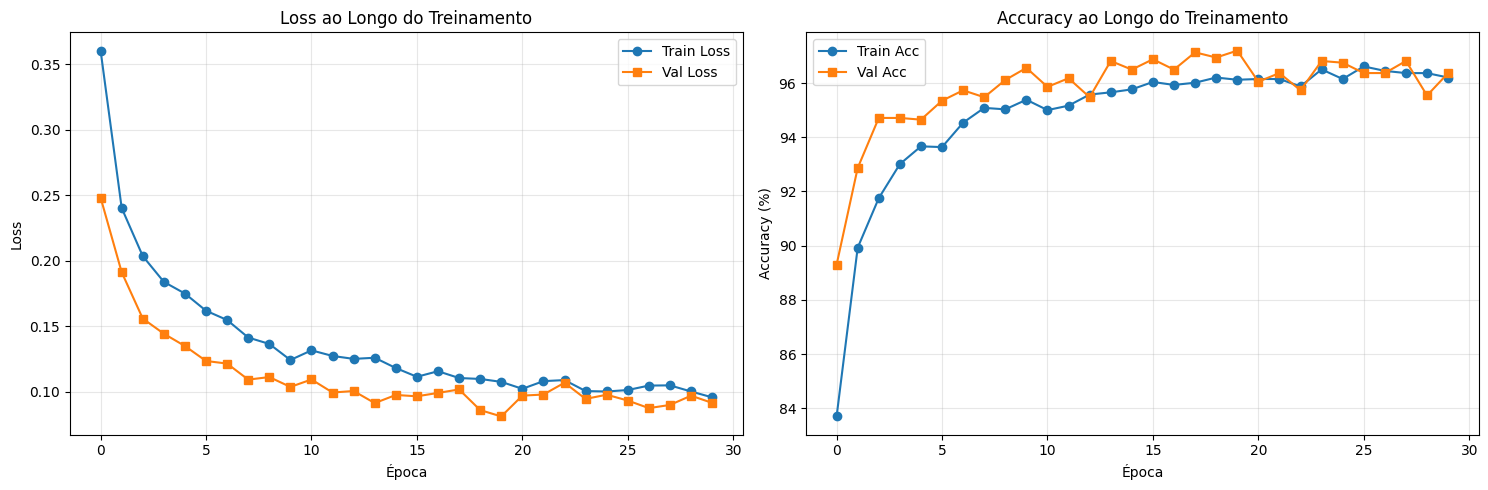

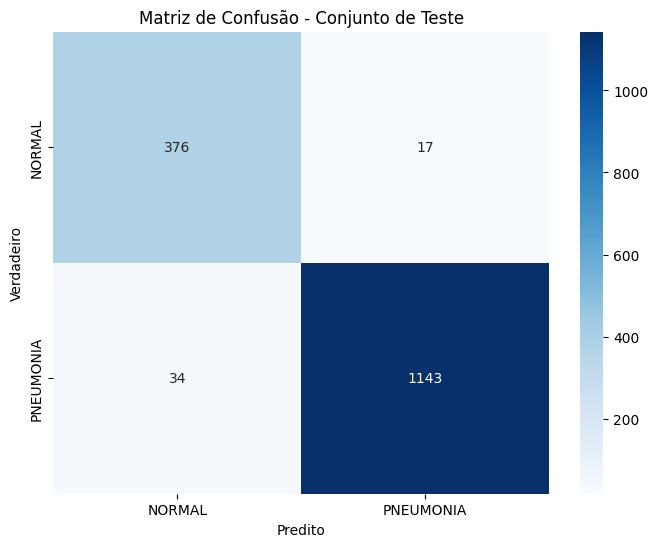

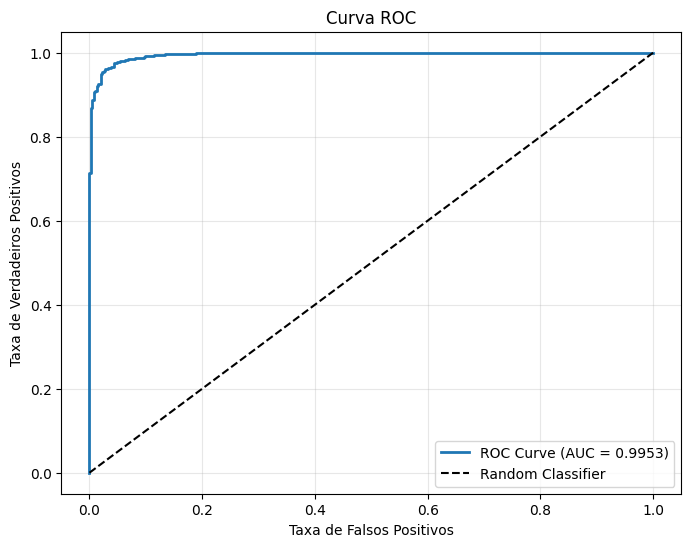

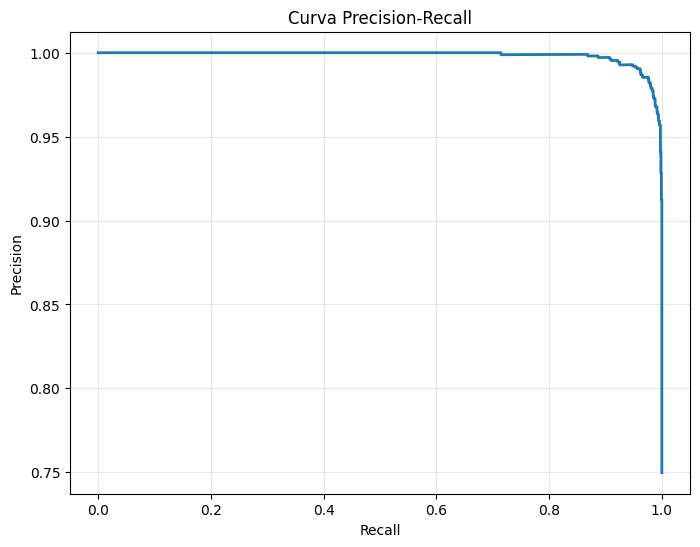

In [29]:
print("\n📊 Gerando gráficos...")
val_loss, val_acc, roc_auc, val_preds, val_labels, val_probs = validate(
    model, val_loader, criterion, device
)
# Gráfico 1: Loss e Accuracy ao longo das épocas
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(val_labels, val_preds)
# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss ao Longo do Treinamento')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy ao Longo do Treinamento')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('colab_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 2: Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão - Conjunto de Teste')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.savefig('colab_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 3: Curva ROC
fpr, tpr, _ = roc_curve(val_labels, val_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('colab_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 4: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(val_labels, val_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True, alpha=0.3)
plt.savefig('colab_precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
